In [129]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import random
import string
import argparse
import math

from tqdm import tqdm
from accelerate import Accelerator
import os
from loguru import logger
import time
import matplotlib.colors as mcolors


import torch.nn.functional as F
import torch.nn.modules.transformer as transformer
from tqdm import tqdm
import json

In [88]:
os.environ['NCCL_DEBUG'] = 'INFO'
os.environ['NCCL_SOCKET_IFNAME'] = 'lo'
os.environ['NCCL_IB_DISABLE'] = '1'
os.environ['NCCL_P2P_LEVEL'] = 'NVL'

# Define constants
MAX_LENGTH = 100
OOD_MAX_LENGTH = 200
VALID_CHARACTERS = ["s", "a", "b", "c", 'd', 'f', 'g', 'x', 'y', 'z', "e", "p"]
MAIN_CHARACTERS = ["a", "b", "c", 'd', 'f', 'g', 'x', 'y', 'z']
START_TOKEN = "s"
END_TOKEN = "e"
PADDING_TOKEN = "p"
VALID_RATIO = 0.5  # Half of the dataset should be valid a*b* strings

data_dir = '/orion/u/yrichard/n/key_trials/test_NOabc_100_200'      # Path to the dir that contains train/test/OOD_dataset.txt, 

# Define constants for model
VOCAB_SIZE = len(VALID_CHARACTERS)
EMBEDDING_DIM = 6
NUM_HEADS = 1
NUM_LAYERS = 1
HIDDEN_DIM = 2
BATCH_SIZE = 256
position_embedding = 'trig'


EPOCHS = 15

# Mapping characters to indices
char_to_index = {ch: idx for idx, ch in enumerate(VALID_CHARACTERS)}



In [89]:
# Custom dataset class
class StringDataset(Dataset):
    def __init__(self, file_path):
        self.data = []
        self.labels = []
        with open(file_path, "r") as f:
            for line in f:
                parts = line.strip().split(" ")
                self.data.append(parts[0])
                self.labels.append(int(parts[1]))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        string = self.data[idx]
        label = self.labels[idx]
        encoded = self.encode_string(string)
        return torch.tensor(encoded, dtype=torch.long), torch.tensor(label, dtype=torch.float32)

    def encode_string(self, string):
        return [char_to_index[char] for char in string]

# Prepare dataset and dataloader
train_dataset = StringDataset(os.path.join(data_dir, "train_dataset.txt"))
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = StringDataset(os.path.join(data_dir,"test_dataset.txt"))
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

ood_dataset = StringDataset(os.path.join(data_dir,"ood_dataset.txt"))
ood_dataloader = DataLoader(ood_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [90]:
# Define a custom TransformerEncoderLayer
class CustomTransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=2, dropout=0.1):
        super(CustomTransformerEncoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.dropout = nn.Dropout(dropout)
        self.layernorm1 = nn.LayerNorm(d_model)
        self.layernorm2 = nn.LayerNorm(d_model)

    def forward(self, src, src_mask=None):
        src = self.layernorm1(
            src + self.self_attn(src, src, src, attn_mask=src_mask)[0]
        )
        src = self.layernorm2(
            src + self.linear2(self.dropout(F.relu(self.linear1(src))))
        )
        return src

class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        # x here is Batchsize x sequence length
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

# Define the model
class TransformerClassifier(nn.Module):
    def __init__(self, embedding_size=4, nhead=1, hidden_dim=2, vocab_size=1500, position_embedding='learnable'):
        super(TransformerClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size, padding_idx=11)

        if position_embedding == 'learnable':
            self.position_embedding = nn.Embedding(vocab_size, embedding_size)
        elif position_embedding == 'trig':
            self.position_embedding = PositionalEncoding(d_model=embedding_size, max_len=vocab_size)

        self.encoder = CustomTransformerEncoderLayer(d_model=embedding_size, nhead=nhead, dim_feedforward=hidden_dim)
        self.fc = nn.Linear(embedding_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):

        if position_embedding == 'learnable':
            x = self.embedding(x) + self.position_embedding(x) # 100(Batchsize) x 200(ood_length) x 4(emb_size)
        elif position_embedding == 'trig':
            x = self.embedding(x)   # 100(Batchsize) x 200(ood_length) x 4(emb_size)
            x = x + self.position_embedding(x.permute(1, 0, 2)).permute(1, 0, 2)



        x = x.transpose(0, 1)   # L x N x Emb

        # attn_mask = (x == 4).transpose(0, 1).unsqueeze(1).repeat(1, x.size(1), x.size(2))
        x = self.encoder(x)     # L x N x Emb

        x = x.transpose(0, 1)   # L x N x Emb
        x = x.mean(dim=1)   # N x L x Emb
        
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

model = TransformerClassifier(vocab_size = OOD_MAX_LENGTH, embedding_size = EMBEDDING_DIM, nhead = NUM_HEADS, hidden_dim = HIDDEN_DIM, position_embedding=position_embedding)
print(f'''Model hyperparameters: VOCAB_SIZE: {VOCAB_SIZE}, EMBEDDING_DIM: {EMBEDDING_DIM}, 
NUM_HEADS:{NUM_HEADS}, HIDDEN_DIM: {HIDDEN_DIM}, NUM_LAYERS: {1}, POSITIONAL_EMBEDDING: {position_embedding}''')


Model hyperparameters: VOCAB_SIZE: 12, EMBEDDING_DIM: 6, 
NUM_HEADS:1, HIDDEN_DIM: 2, NUM_LAYERS: 1, POSITIONAL_EMBEDDING: trig


In [113]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=5e-3)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

In [114]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == "cpu" and torch.backends.mps.is_available():
    device = torch.device("mps")
model.to(device)

TransformerClassifier(
  (embedding): Embedding(200, 6, padding_idx=11)
  (position_embedding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): CustomTransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=6, out_features=6, bias=True)
    )
    (linear1): Linear(in_features=6, out_features=2, bias=True)
    (linear2): Linear(in_features=2, out_features=6, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (layernorm1): LayerNorm((6,), eps=1e-05, elementwise_affine=True)
    (layernorm2): LayerNorm((6,), eps=1e-05, elementwise_affine=True)
  )
  (fc): Linear(in_features=6, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [115]:
accelerator = Accelerator()
model, optimizer, train_dataloader, test_dataloader, ood_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, test_dataloader, ood_dataloader
)

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [116]:
if accelerator.is_main_process:
        # Evaluate the model
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in tqdm(train_dataloader):
                outputs = model(inputs)
                predicted = torch.round(outputs)
                total += labels.size(0)
                correct += (predicted.squeeze() == labels).sum().item()
        print(f"Initial Accuracy on train split: {correct/total}")


  0%|          | 0/625 [00:00<?, ?it/s]

100%|██████████| 625/625 [00:06<00:00, 94.95it/s] 

Initial Accuracy on train split: 0.65623125


In [117]:
# Training loop
for epoch in range(EPOCHS):
    model.train()
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_dataloader):
        optimizer.zero_grad()
        outputs = model(inputs)
        predicted = torch.round(outputs)
        total += labels.size(0)
        correct += (predicted.squeeze() == labels).sum().item()
        loss = criterion(outputs.squeeze(), labels)
        accelerator.backward(loss)
        optimizer.step()
    # scheduler.step()
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {loss.item()}, Training Accuracy: {correct/total}, Loss: {scheduler.get_last_lr()[0]}")


100%|██████████| 625/625 [00:10<00:00, 61.88it/s]


Epoch 1/15, Loss: 0.6292905807495117, Training Accuracy: 0.65160625, Loss: 0.005


100%|██████████| 625/625 [00:09<00:00, 63.55it/s]


Epoch 2/15, Loss: 0.6117385625839233, Training Accuracy: 0.65259375, Loss: 0.005


100%|██████████| 625/625 [00:09<00:00, 63.74it/s]


Epoch 3/15, Loss: 0.6211010217666626, Training Accuracy: 0.65106875, Loss: 0.005


100%|██████████| 625/625 [00:10<00:00, 61.55it/s]


Epoch 4/15, Loss: 0.6372374296188354, Training Accuracy: 0.652125, Loss: 0.005


100%|██████████| 625/625 [00:09<00:00, 62.72it/s]


Epoch 5/15, Loss: 0.6306643486022949, Training Accuracy: 0.6532875, Loss: 0.005


100%|██████████| 625/625 [00:09<00:00, 62.70it/s]


Epoch 6/15, Loss: 0.6072548627853394, Training Accuracy: 0.65214375, Loss: 0.005


100%|██████████| 625/625 [00:09<00:00, 62.98it/s]


Epoch 7/15, Loss: 0.6496293544769287, Training Accuracy: 0.65203125, Loss: 0.005


100%|██████████| 625/625 [00:10<00:00, 62.26it/s]


Epoch 8/15, Loss: 0.6411176323890686, Training Accuracy: 0.65263125, Loss: 0.005


100%|██████████| 625/625 [00:10<00:00, 62.42it/s]


Epoch 9/15, Loss: 0.6203830242156982, Training Accuracy: 0.653175, Loss: 0.005


100%|██████████| 625/625 [00:10<00:00, 61.89it/s]


Epoch 10/15, Loss: 0.6199188232421875, Training Accuracy: 0.6528625, Loss: 0.005


100%|██████████| 625/625 [00:09<00:00, 62.82it/s]


Epoch 11/15, Loss: 0.5722416639328003, Training Accuracy: 0.6530625, Loss: 0.005


100%|██████████| 625/625 [00:09<00:00, 64.45it/s]


Epoch 12/15, Loss: 0.6070902347564697, Training Accuracy: 0.6534125, Loss: 0.005


100%|██████████| 625/625 [00:09<00:00, 62.72it/s]


Epoch 13/15, Loss: 0.6023359894752502, Training Accuracy: 0.6519625, Loss: 0.005


100%|██████████| 625/625 [00:09<00:00, 63.90it/s]


Epoch 14/15, Loss: 0.6490086317062378, Training Accuracy: 0.65333125, Loss: 0.005


100%|██████████| 625/625 [00:09<00:00, 64.06it/s]

Epoch 15/15, Loss: 0.5807613730430603, Training Accuracy: 0.6531125, Loss: 0.005


# Save the trained model
if accelerator.is_main_process:
    model_path = os.path.join(data_dir, f'model_{EMBEDDING_DIM}_{NUM_HEADS}_{NUM_LAYERS}_{EPOCHS}.pth')
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")


In [118]:
# Print accuracy of the model
if accelerator.is_main_process:
    # Evaluate the model
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(test_dataloader):
            outputs = model(inputs)
            predicted = torch.round(outputs)
            total += labels.size(0)
            correct += (predicted.squeeze() == labels).sum().item()
    print(f"Test Accuracy: {correct/total}")


100%|██████████| 157/157 [00:01<00:00, 94.79it/s] 

Test Accuracy: 0.642525


In [119]:
# Print accuracy of the model on OOD dataset
if accelerator.is_main_process:
    # Evaluate the model
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(ood_dataloader):
            outputs = model(inputs)
            predicted = torch.round(outputs)
            total += labels.size(0)
            correct += (predicted.squeeze() == labels).sum().item()
    print(f"OOD Accuracy: {correct/total}")


100%|██████████| 118/118 [00:01<00:00, 88.59it/s]

OOD Accuracy: 0.6274


# Interpretability

In [120]:
data_iterator = iter(train_dataloader)
single_batch = next(data_iterator)
sample = single_batch[0][0].unsqueeze(0)
sample.shape

torch.Size([1, 200])

In [121]:
sample.shape

torch.Size([1, 200])

tensor([[0.4132]], grad_fn=<SigmoidBackward0>)
tensor([46, 40, 48, 39, 51, 50,  2, 49, 44, 32, 43, 31, 42,  3,  8, 26,  7,  9,
        25,  4,  6, 13, 33, 12, 11, 17, 47, 45, 52, 41])
Original string:  sbcaabccccbcccbbacbbababbccbaabccabbbbbccbaaabcbcaaabepppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppp
Original list:  ['s', 'b', 'c', 'a', 'a', 'b', 'c', 'c', 'c', 'c', 'b', 'c', 'c', 'c', 'b', 'b', 'a', 'c', 'b', 'b', 'a', 'b', 'a', 'b', 'b', 'c', 'c', 'b', 'a', 'a', 'b', 'c', 'c', 'a', 'b', 'b', 'b', 'b', 'b', 'c', 'c', 'b', 'a', 'a', 'a', 'b', 'c', 'b', 'c', 'a', 'a', 'a', 'b', 'e', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 

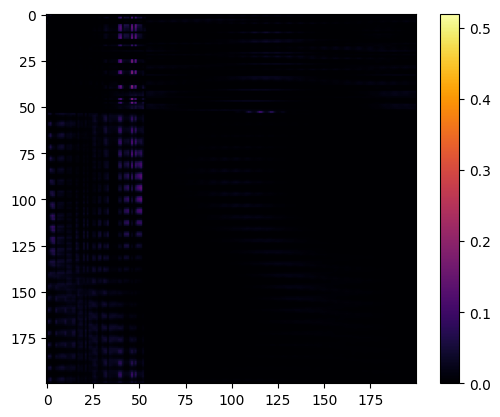

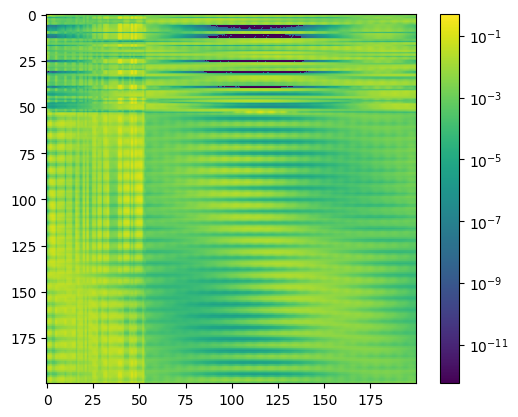

In [143]:
# Load model, pick random sample from training set and print attention weights
model = model.to('cpu')

model.eval()

data_iterator = iter(train_dataloader)
single_batch = next(data_iterator)
sample = single_batch[0][1]  # Adjust indexing if your dataloader returns multiple values like (features, labels)

x = sample.unsqueeze(0).to('cpu')

output = model(x)
print(output)

if position_embedding == 'learnable':
    x = model.embedding(x) + self.model.position_embedding(x) # 100(Batchsize) x 200(ood_length) x 4(emb_size)
elif position_embedding == 'trig':
    x = model.embedding(x)   # 100(Batchsize) x 200(ood_length) x 4(emb_size)
    x = x + model.position_embedding(x.permute(1, 0, 2)).permute(1, 0, 2)

x = x.transpose(0, 1) 
attn_weights = model.encoder.self_attn(x, x, x, attn_mask=None)[1]      # 100(Batchsize) 200(ood_length) x x 4(emb_size)
# print(attn_weights.squeeze(0).mean(dim=0))
# Print indices of top 10 attention weights
print(torch.topk(attn_weights.squeeze(0).mean(dim=0), 30).indices)

# Print the original string
original_string = "".join(VALID_CHARACTERS[i] for i in sample.tolist())
original_list = list(original_string)
original_dict = {i:original_list[i] for i in range(len(original_list))}
# Plot matrix of attention weights
print('Original string: ',"".join(VALID_CHARACTERS[i] for i in sample.tolist()))
print('Original list: ', original_list)

with open('original_dict.json', 'w') as file:
    json.dump(original_dict, file, indent=4)

# Plot matrix of attention weights
import matplotlib.pyplot as plt

shown = attn_weights.squeeze(0).detach().numpy()

# plt.imshow(shown)
# plt.colorbar()
# plt.show()

min_val, max_val = shown.min(), shown.max()
print(min_val, max_val)
range_val = max_val - min_val

plt.imshow(shown, cmap='inferno', vmin=min_val, vmax=max_val)
plt.colorbar()
plt.show()

norm = mcolors.LogNorm(vmin=shown[shown > 0].min(), vmax=shown.max())
plt.imshow(shown, cmap='viridis', norm=norm)
plt.colorbar()
plt.show()


In [140]:
attn_weights.shape

torch.Size([1, 200, 200])